In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import savgol_filter, find_peaks
from scipy.stats import circmean
import fly_analysis as fa
from tqdm import tqdm

In [2]:
root_folder = "/home/buchsbaum/mnt/md0/Experiments/"

# Process j53xu68 files
print("Processing j53xu68 files")
j53xu68_files = ["20230321_162524.braidz", "20230519_130210.braidz"]
j53_data = fa.braidz.read_multiple_braidz(j53xu68_files, root_folder)

# Process g29xu68 files
print("Processing g29xu68 files")
g29xu68_files = ["20230512_144203.braidz", "20230203_145747.braidz"]
g29_data = fa.braidz.read_multiple_braidz(g29xu68_files, root_folder)

# Process emptyxu68 files
print("Processing emptyxu68 files")
emptyxu68_files = ["20231020_150051.braidz", "20230530_115028.braidz",]
empty_data = fa.braidz.read_multiple_braidz(emptyxu68_files, root_folder)

Processing j53xu68 files
Reading /home/buchsbaum/mnt/md0/Experiments/20230321_162524.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20230519_130210.braidz using pyarrow
Processing g29xu68 files
Reading /home/buchsbaum/mnt/md0/Experiments/20230512_144203.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20230203_145747.braidz using pyarrow
Processing emptyxu68 files
Reading /home/buchsbaum/mnt/md0/Experiments/20231020_150051.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20230530_115028.braidz using pyarrow


In [7]:
def sg_smooth(df):
    columns = ["x", "y", "z", "xvel", "yvel", "zvel"]
    df[columns] = df[columns].apply(lambda x: savgol_filter(x, 21, 3))
    return df


def get_angular_velocity(xvel, yvel):
    theta = np.arctan2(yvel, xvel)
    theta_unwrap = np.unwrap(theta)
    return np.gradient(theta_unwrap, 0.01)


def get_linear_velocity(xvel, yvel):
    return np.sqrt(xvel**2 + yvel**2)


def get_saccades(angular_velocity, **kwargs):
    return find_peaks(
        np.abs(angular_velocity),
        height=kwargs.get("height", np.deg2rad(300)),
        distance=kwargs.get("distance", 20),
    )[0]


def plot_mean_and_std(arr, ax=None, take_abs=True, label=None):
    if ax is None:
        _, ax = plt.subplots()

    if take_abs:
        arr = np.abs(arr)

    mean = np.nanmean(arr, axis=0)
    std = np.nanstd(arr, axis=0)

    X = np.arange(len(mean))*0.01
    ax.plot(X, mean, label=label)
    ax.fill_between(
        X, mean - std, mean + std, alpha=0.2,
    )
    return ax

def plot_histogram(arr, ax=None, label=None):
    if ax is None:
        _, ax = plt.subplots()

    sns.histplot(
        arr,
        ax=ax,
        bins=36,
        binrange=(-np.pi, np.pi),
        stat="density",
        kde=True,
    )
    return ax

def calculate_heading_change(xvel, yvel, idx, n):
    # Calculate heading angle
    heading = np.arctan2(yvel, xvel)

    # Calculate average heading before stim_idx
    before_heading = np.nanmean(heading[idx - n : idx])

    # Calculate average heading after stim_idx
    after_heading = np.nanmean(heading[idx + 1 : idx + n + 1])

    # Calculate the change in heading
    heading_change = after_heading - before_heading

    # Normalize the change to be between -pi and pi
    heading_change = (heading_change + np.pi) % (2 * np.pi) - np.pi

    return heading_change


In [4]:
def get_data_only_stim(df, stim, min_group_size=150, height=500, distance=40, n=50, min_linvel=0.05, heading_change_n = 25):
    angvel = []
    linvel = []
    heading = []
    group = []

    for _, row in tqdm(stim.iterrows(), total=len(stim)):
        obj_id = row["obj_id"]
        exp_num = row["exp_num"]

        grp = df[(df["obj_id"] == obj_id) & (df["exp_num"] == exp_num)]

        if len(grp) < min_group_size:
            continue

        try:
            stim_idx = np.where(grp.frame == row["frame"])[0][0]
        except IndexError:
            stim_idx = None

        grp = sg_smooth(grp)
        angular_velocity = get_angular_velocity(
            grp.xvel.to_numpy(), grp.yvel.to_numpy()
        )
        #angular_velocity = savgol_filter(angular_velocity, 21, 3)
        linear_velocity = get_linear_velocity(grp.xvel.to_numpy(), grp.yvel.to_numpy())
        saccades = get_saccades(angular_velocity, height=np.deg2rad(height), distance=distance)
        angular_velocity = np.rad2deg(angular_velocity)
        saccades = saccades[linear_velocity[saccades] > min_linvel]

        for saccade in saccades:
            if saccade - n < 0 or saccade + n >= len(angular_velocity):
                continue

            slice_range = slice(saccade - n, saccade + n)

            # check if at any point in the slice the linear velocity is lower than 0.1; if it is, skip the saccade
            # if any(linear_velocity[slice_range] < 0.1):
            #     continue

            angvel.append(angular_velocity[slice_range])
            linvel.append(linear_velocity[slice_range])

            heading_change = calculate_heading_change(
                grp.xvel.to_numpy(), grp.yvel.to_numpy(), saccade, heading_change_n
            )
            heading.append(heading_change)

            # check if saccade happend after stim_idx within 30 frames
            is_stim = stim_idx is not None and stim_idx < saccade < stim_idx + 30
            group.append("stim" if is_stim else "spont")


    return np.array(angvel), np.array(linvel), np.array(heading), np.array(group)

In [13]:
def get_stim_saccade(df, stim):
    angvels = []
    linvels = []
    heading_changes = []

    for _, row in tqdm(stim.iterrows(), total = len(stim)):
        obj_id = row["obj_id"]
        exp_num = row["exp_num"]
        frame = row["frame"]

        grp = df[(df["obj_id"] == obj_id) & (df["exp_num"] == exp_num)]

        if len(grp) < 150:
            continue

        try:
            stim_idx = np.where(grp.frame == frame)[0][0]
        except IndexError:
            continue

        if stim_idx - 50 <0 or stim_idx + 100 >= len(grp):
            continue

        grp = sg_smooth(grp)
        angular_velocity = get_angular_velocity(
            grp.xvel.to_numpy(), grp.yvel.to_numpy()
        )
        linear_velocity = get_linear_velocity(grp.xvel.to_numpy(), grp.yvel.to_numpy())

        index_slice = slice(stim_idx-50, stim_idx+100)

        angular_velocity_slice = angular_velocity[index_slice]
        linear_velocity_slice = linear_velocity[index_slice]
        
        heading_change = calculate_heading_change(
            grp.xvel.to_numpy(), grp.yvel.to_numpy(), stim_idx, 25
        )
    
    return np.array(angvels), np.array(linvels), np.array(heading_changes)

In [6]:
g29_angvels, g29_linvels, g29_heading_changes, g29_group = get_data_only_stim(
    g29_data["df"], g29_data["stim"],
)
g29_stim_angvels, g29_stim_linvels, g29_stim_heading_changes = get_stim_saccade(
    g29_data["df"], g29_data["stim"],
)
del g29_data

j53_angvels, j53_linvels, j53_heading_changes, j53_group = get_data_only_stim(
    j53_data["df"], j53_data["stim"],
)
j53_stim_angvels, j53_stim_linvels, j53_stim_heading_changes = get_stim_saccade(
    j53_data["df"], j53_data["stim"],
)
del j53_data

empty_angvels, empty_linvels, empty_heading_changes, empty_group = get_data_only_stim(
    empty_data["df"], empty_data["stim"],
)
empty_stim_angvels, empty_stim_linvels, empty_stim_heading_changes = get_stim_saccade(
    empty_data["df"], empty_data["stim"],
)
del empty_data

100%|██████████| 389/389 [00:30<00:00, 12.64it/s]



Analysis for AX-Split
Model Comparison:
Components | BIC     | AIC     | Log-Likelihood
-----------+---------+---------+----------------
1          | 6613.02 | 6602.36 | -3299.18       
2          | 6188.55 | 6161.90 | -3075.95       
3          | 5662.06 | 5619.43 | -2801.71       


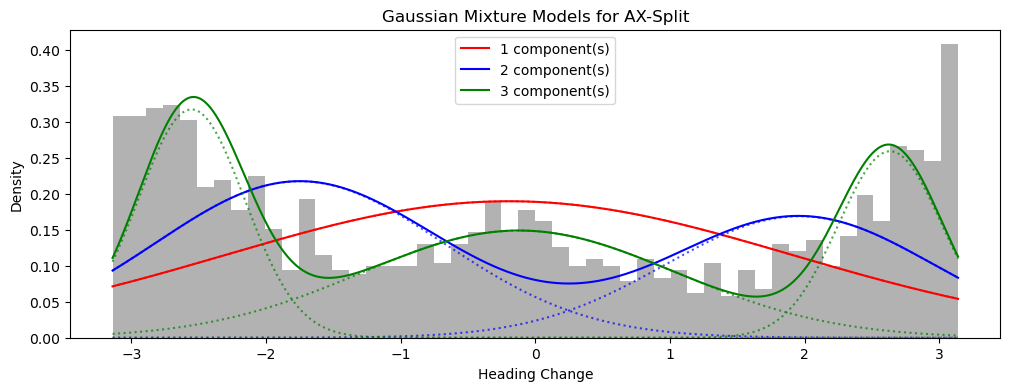


Analysis for DNp03
Model Comparison:
Components | BIC     | AIC     | Log-Likelihood
-----------+---------+---------+----------------
1          | 1967.77 | 1959.34 | -977.67        
2          | 1947.75 | 1926.68 | -958.34        
3          | 1894.48 | 1860.77 | -922.38        


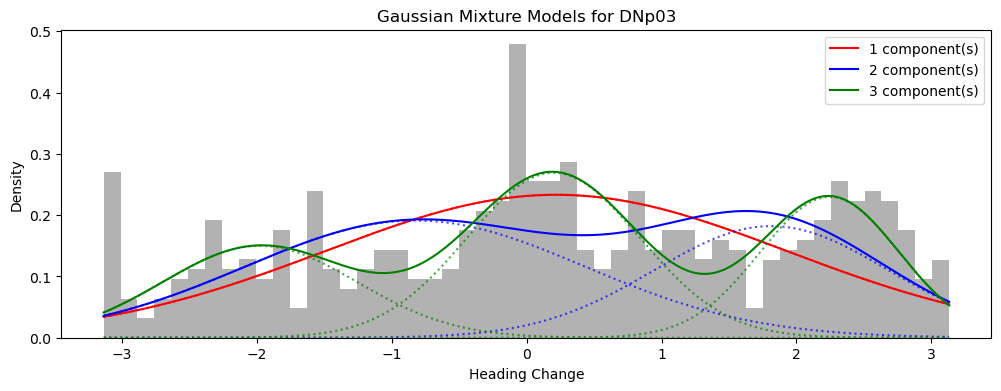


Analysis for Empty-Split
Model Comparison:
Components | BIC     | AIC     | Log-Likelihood
-----------+---------+---------+----------------
1          | 1186.42 | 1178.60 | -587.30        
2          | 1204.68 | 1185.14 | -587.57        
3          | 1207.72 | 1176.46 | -580.23        


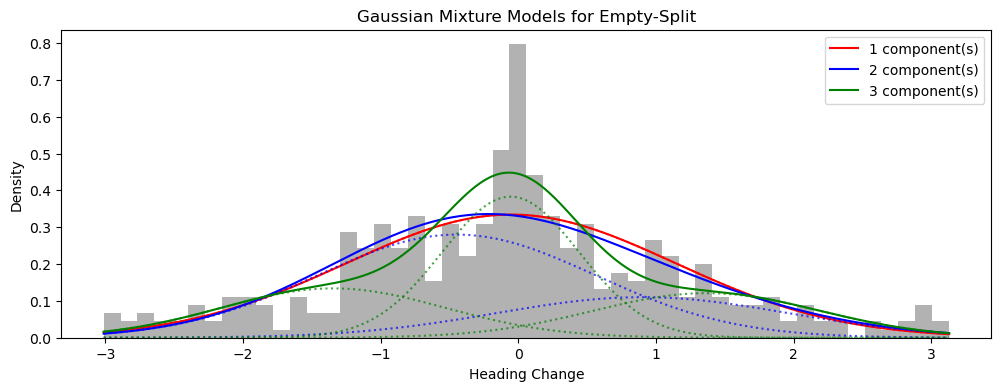

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from scipy.special import logsumexp

def fit_and_compare_gmm(data, max_components=3, n_init=10):
    """
    Fit Gaussian Mixture Models with 1 to max_components components and compare them.
    
    :param data: 1D numpy array of heading change data
    :param max_components: Maximum number of components to consider
    :param n_init: Number of initializations for each GMM
    :return: Dictionary with results for each number of components
    """
    results = {}
    X = data.reshape(-1, 1)
    
    for n_components in range(1, max_components + 1):
        gmm = GaussianMixture(n_components=n_components, n_init=n_init, random_state=42)
        gmm.fit(X)
        
        # Calculate BIC and AIC
        bic = gmm.bic(X)
        aic = gmm.aic(X)
        
        # Calculate log-likelihood
        log_likelihood = gmm.score(X) * X.shape[0]
        
        results[n_components] = {
            'gmm': gmm,
            'bic': bic,
            'aic': aic,
            'log_likelihood': log_likelihood
        }
    
    return results

def plot_results(data, results, group_name):
    """
    Plot the data histogram and fitted GMMs.
    
    :param data: 1D numpy array of heading change data
    :param results: Dictionary with GMM results
    :param group_name: Name of the group (e.g., 'Control', 'Group 1', 'Group 2')
    """
    plt.figure(figsize=(12, 4))
    
    # Plot histogram of data
    plt.hist(data, bins=50, density=True, alpha=0.6, color='gray')
    
    # Plot fitted GMMs
    x = np.linspace(data.min(), data.max(), 1000).reshape(-1, 1)
    colors = ['red', 'blue', 'green']
    
    for i, (n_components, result) in enumerate(results.items()):
        gmm = result['gmm']
        y = np.exp(gmm.score_samples(x))
        plt.plot(x, y, color=colors[i], label=f'{n_components} component(s)')
        
        # Plot individual Gaussian components
        for j, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
            y = gmm.weights_[j] * norm.pdf(x, mean, np.sqrt(covar)).ravel()
            plt.plot(x, y, color=colors[i], linestyle=':', alpha=0.7)
    
    plt.title(f'Gaussian Mixture Models for {group_name}')
    plt.xlabel('Heading Change')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def print_results(results):
    """
    Print the comparison results.
    
    :param results: Dictionary with GMM results
    """
    print("Model Comparison:")
    print("Components | BIC     | AIC     | Log-Likelihood")
    print("-----------+---------+---------+----------------")
    for n_components, result in results.items():
        print(f"{n_components:<11}| {result['bic']:<8.2f}| {result['aic']:<8.2f}| {result['log_likelihood']:<15.2f}")

# Example usage
np.random.seed(42)

# Analyze each group
for group_name, data in [("AX-Split", g29_stim_heading_changes), ("DNp03", j53_stim_heading_changes), ("Empty-Split", empty_stim_heading_changes)]:
    print(f"\nAnalysis for {group_name}")
    results = fit_and_compare_gmm(data)
    print_results(results)
    plot_results(data, results, group_name)


Analysis for AX-Split
Model Comparison:
Components | BIC     | AIC     | Log-Likelihood
-----------+---------+---------+----------------
1          | 6613.02 | 6602.36 | -3299.18       
2          | 6188.55 | 6161.90 | -3075.95       
3          | 5662.06 | 5619.43 | -2801.71       


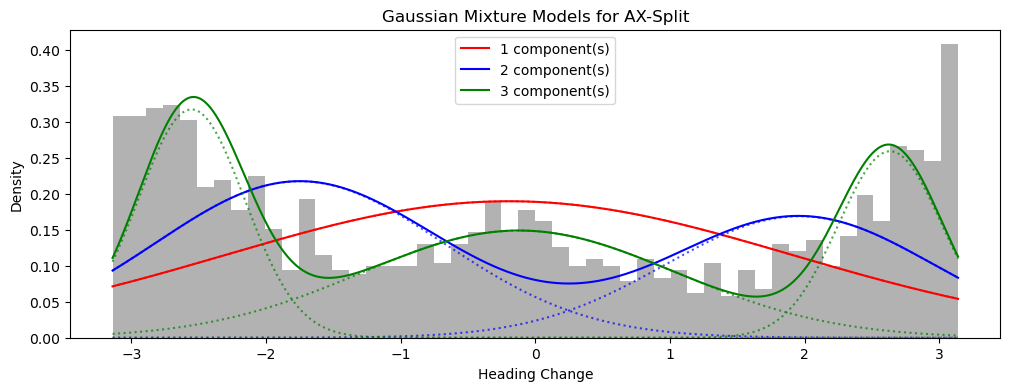


Analysis for DNp03
Model Comparison:
Components | BIC     | AIC     | Log-Likelihood
-----------+---------+---------+----------------
1          | 1967.77 | 1959.34 | -977.67        
2          | 1947.75 | 1926.68 | -958.34        
3          | 1894.48 | 1860.77 | -922.38        


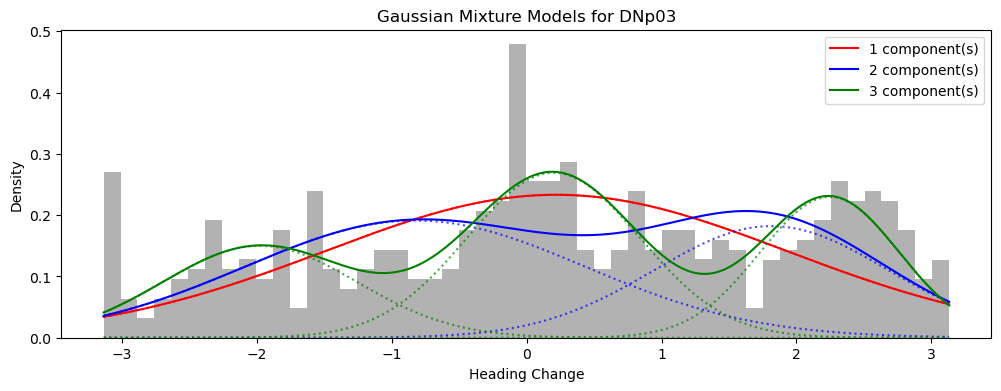


Analysis for Empty-Split
Model Comparison:
Components | BIC     | AIC     | Log-Likelihood
-----------+---------+---------+----------------
1          | 1186.42 | 1178.60 | -587.30        
2          | 1204.68 | 1185.14 | -587.57        
3          | 1207.72 | 1176.46 | -580.23        


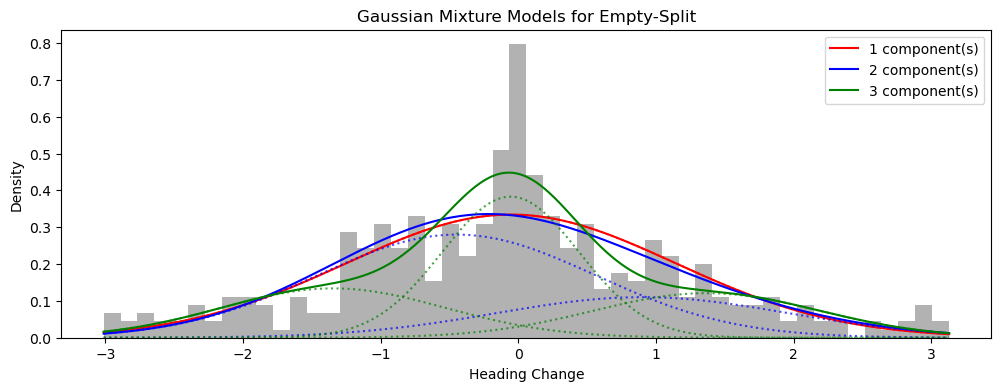

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from scipy.special import logsumexp

def fit_and_compare_gmm(data, max_components=3, n_init=10):
    """
    Fit Gaussian Mixture Models with 1 to max_components components and compare them.
    
    :param data: 1D numpy array of heading change data
    :param max_components: Maximum number of components to consider
    :param n_init: Number of initializations for each GMM
    :return: Dictionary with results for each number of components
    """
    results = {}
    X = data.reshape(-1, 1)
    
    for n_components in range(1, max_components + 1):
        gmm = GaussianMixture(n_components=n_components, n_init=n_init, random_state=42)
        gmm.fit(X)
        
        # Calculate BIC and AIC
        bic = gmm.bic(X)
        aic = gmm.aic(X)
        
        # Calculate log-likelihood
        log_likelihood = gmm.score(X) * X.shape[0]
        
        results[n_components] = {
            'gmm': gmm,
            'bic': bic,
            'aic': aic,
            'log_likelihood': log_likelihood
        }
    
    return results

def plot_results(data, results, group_name):
    """
    Plot the data histogram and fitted GMMs.
    
    :param data: 1D numpy array of heading change data
    :param results: Dictionary with GMM results
    :param group_name: Name of the group (e.g., 'Control', 'Group 1', 'Group 2')
    """
    plt.figure(figsize=(12, 4))
    
    # Plot histogram of data
    plt.hist(data, bins=50, density=True, alpha=0.6, color='gray')
    
    # Plot fitted GMMs
    x = np.linspace(data.min(), data.max(), 1000).reshape(-1, 1)
    colors = ['red', 'blue', 'green']
    
    for i, (n_components, result) in enumerate(results.items()):
        gmm = result['gmm']
        y = np.exp(gmm.score_samples(x))
        plt.plot(x, y, color=colors[i], label=f'{n_components} component(s)')
        
        # Plot individual Gaussian components
        for j, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
            y = gmm.weights_[j] * norm.pdf(x, mean, np.sqrt(covar)).ravel()
            plt.plot(x, y, color=colors[i], linestyle=':', alpha=0.7)
    
    plt.title(f'Gaussian Mixture Models for {group_name}')
    plt.xlabel('Heading Change')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def print_results(results):
    """
    Print the comparison results.
    
    :param results: Dictionary with GMM results
    """
    print("Model Comparison:")
    print("Components | BIC     | AIC     | Log-Likelihood")
    print("-----------+---------+---------+----------------")
    for n_components, result in results.items():
        print(f"{n_components:<11}| {result['bic']:<8.2f}| {result['aic']:<8.2f}| {result['log_likelihood']:<15.2f}")

# Example usage
np.random.seed(42)

# Analyze each group
for group_name, data in [("AX-Split", g29_stim_heading_changes), ("DNp03", j53_stim_heading_changes), ("Empty-Split", empty_stim_heading_changes)]:
    print(f"\nAnalysis for {group_name}")
    results = fit_and_compare_gmm(data)
    print_results(results)
    plot_results(data, results, group_name)


Analysis for AX-Split
Model Comparison:
Components | BIC     | AIC     | Log-Likelihood
-----------+---------+---------+----------------
1          | 6613.02 | 6602.36 | -3299.18       
2          | 6188.55 | 6161.90 | -3075.95       
3          | 5662.06 | 5619.43 | -2801.71       


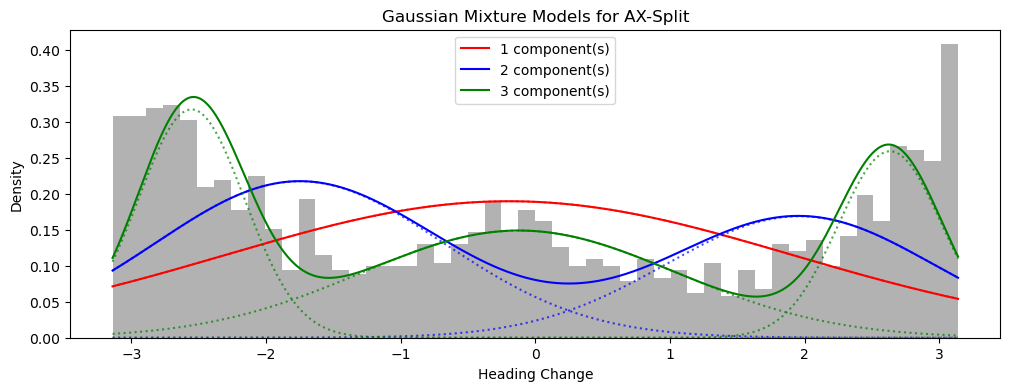


Analysis for DNp03
Model Comparison:
Components | BIC     | AIC     | Log-Likelihood
-----------+---------+---------+----------------
1          | 1967.77 | 1959.34 | -977.67        
2          | 1947.75 | 1926.68 | -958.34        
3          | 1894.48 | 1860.77 | -922.38        


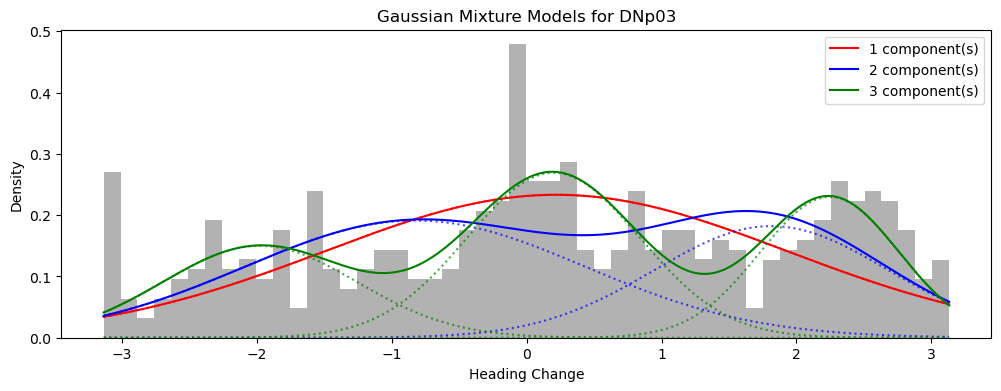


Analysis for Empty-Split
Model Comparison:
Components | BIC     | AIC     | Log-Likelihood
-----------+---------+---------+----------------
1          | 1186.42 | 1178.60 | -587.30        
2          | 1204.68 | 1185.14 | -587.57        
3          | 1207.72 | 1176.46 | -580.23        


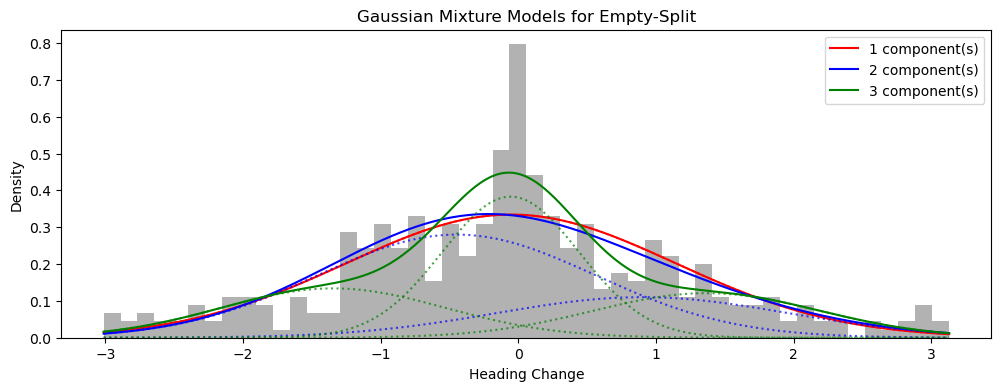

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from scipy.special import logsumexp

def fit_and_compare_gmm(data, max_components=3, n_init=10):
    """
    Fit Gaussian Mixture Models with 1 to max_components components and compare them.
    
    :param data: 1D numpy array of heading change data
    :param max_components: Maximum number of components to consider
    :param n_init: Number of initializations for each GMM
    :return: Dictionary with results for each number of components
    """
    results = {}
    X = data.reshape(-1, 1)
    
    for n_components in range(1, max_components + 1):
        gmm = GaussianMixture(n_components=n_components, n_init=n_init, random_state=42)
        gmm.fit(X)
        
        # Calculate BIC and AIC
        bic = gmm.bic(X)
        aic = gmm.aic(X)
        
        # Calculate log-likelihood
        log_likelihood = gmm.score(X) * X.shape[0]
        
        results[n_components] = {
            'gmm': gmm,
            'bic': bic,
            'aic': aic,
            'log_likelihood': log_likelihood
        }
    
    return results

def plot_results(data, results, group_name):
    """
    Plot the data histogram and fitted GMMs.
    
    :param data: 1D numpy array of heading change data
    :param results: Dictionary with GMM results
    :param group_name: Name of the group (e.g., 'Control', 'Group 1', 'Group 2')
    """
    plt.figure(figsize=(12, 4))
    
    # Plot histogram of data
    plt.hist(data, bins=50, density=True, alpha=0.6, color='gray')
    
    # Plot fitted GMMs
    x = np.linspace(data.min(), data.max(), 1000).reshape(-1, 1)
    colors = ['red', 'blue', 'green']
    
    for i, (n_components, result) in enumerate(results.items()):
        gmm = result['gmm']
        y = np.exp(gmm.score_samples(x))
        plt.plot(x, y, color=colors[i], label=f'{n_components} component(s)')
        
        # Plot individual Gaussian components
        for j, (mean, covar) in enumerate(zip(gmm.means_, gmm.covariances_)):
            y = gmm.weights_[j] * norm.pdf(x, mean, np.sqrt(covar)).ravel()
            plt.plot(x, y, color=colors[i], linestyle=':', alpha=0.7)
    
    plt.title(f'Gaussian Mixture Models for {group_name}')
    plt.xlabel('Heading Change')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def print_results(results):
    """
    Print the comparison results.
    
    :param results: Dictionary with GMM results
    """
    print("Model Comparison:")
    print("Components | BIC     | AIC     | Log-Likelihood")
    print("-----------+---------+---------+----------------")
    for n_components, result in results.items():
        print(f"{n_components:<11}| {result['bic']:<8.2f}| {result['aic']:<8.2f}| {result['log_likelihood']:<15.2f}")

# Example usage
np.random.seed(42)

# Analyze each group
for group_name, data in [("AX-Split", g29_stim_heading_changes), ("DNp03", j53_stim_heading_changes), ("Empty-Split", empty_stim_heading_changes)]:
    print(f"\nAnalysis for {group_name}")
    results = fit_and_compare_gmm(data)
    print_results(results)
    plot_results(data, results, group_name)

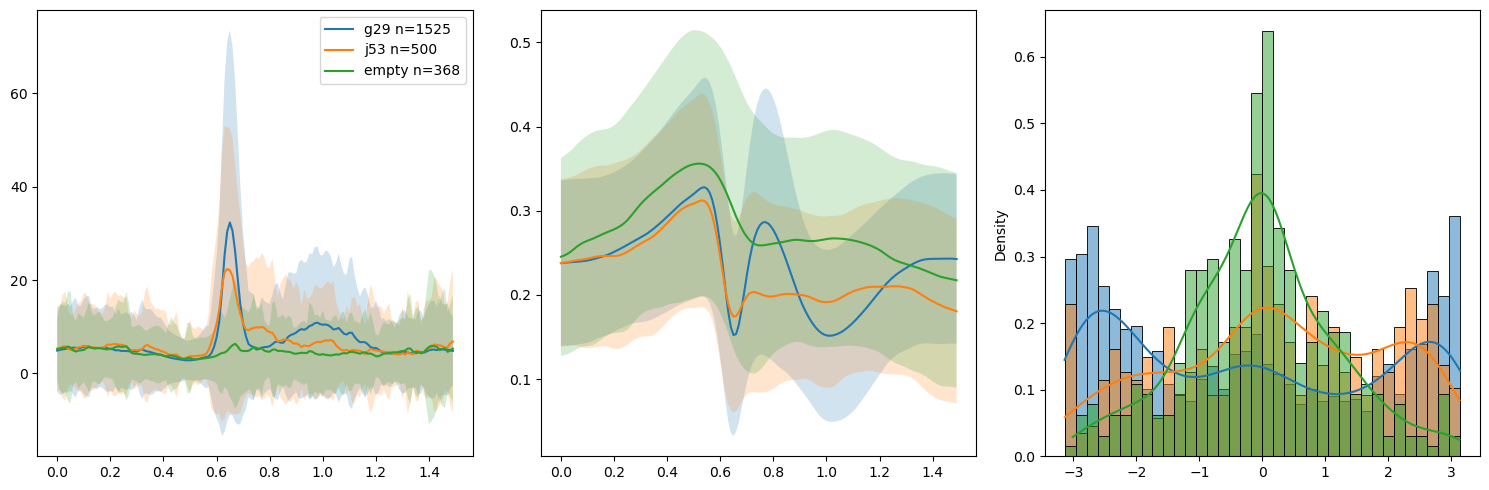

In [11]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

# angular velocity
plot_mean_and_std(g29_stim_angvels, ax=axs[0], label=f"g29 n={len(g29_stim_angvels)}")
plot_mean_and_std(j53_stim_angvels, ax=axs[0], label=f"j53 n={len(j53_stim_angvels)}")
plot_mean_and_std(empty_stim_angvels, ax=axs[0], label=f"empty n={len(empty_stim_angvels)}")

# linear velocity
plot_mean_and_std(g29_stim_linvels, ax=axs[1], label="g29")
plot_mean_and_std(j53_stim_linvels, ax=axs[1], label="j53")
plot_mean_and_std(empty_stim_linvels, ax=axs[1], label="empty")

# heading change
plot_histogram(g29_stim_heading_changes, ax=axs[2], label="g29")
plot_histogram(j53_stim_heading_changes, ax=axs[2], label="j53")
plot_histogram(empty_stim_heading_changes, ax=axs[2], label="empty")

axs[0].legend()
plt.tight_layout()
plt.show()

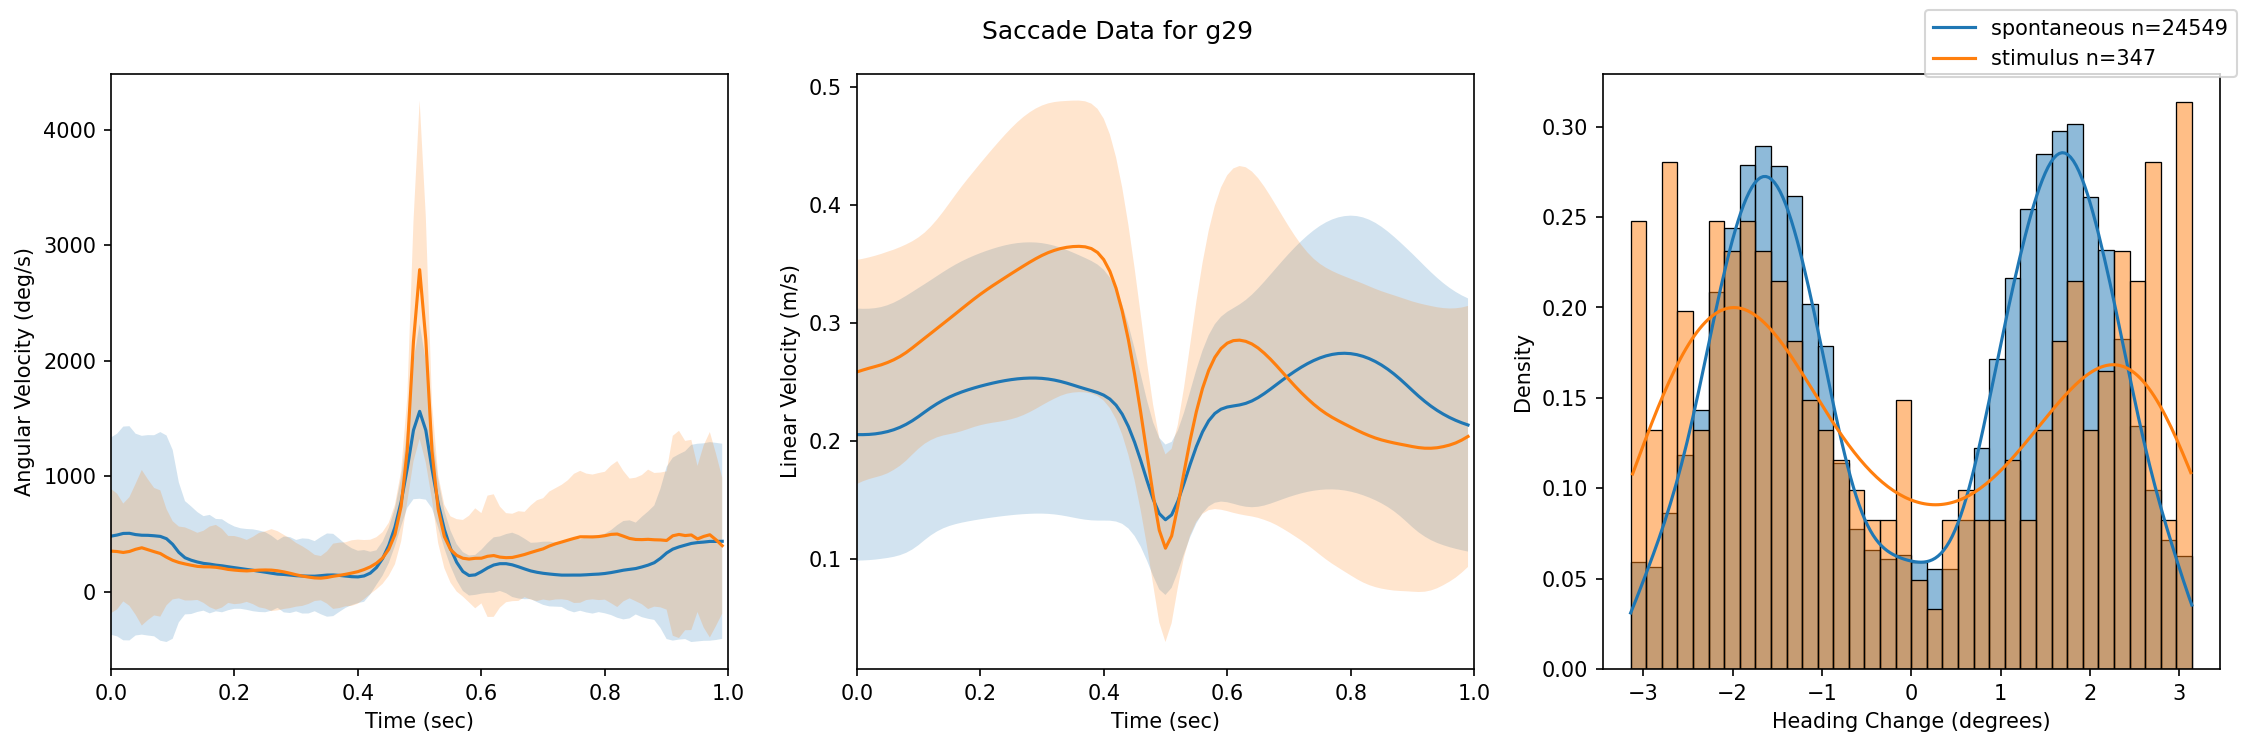

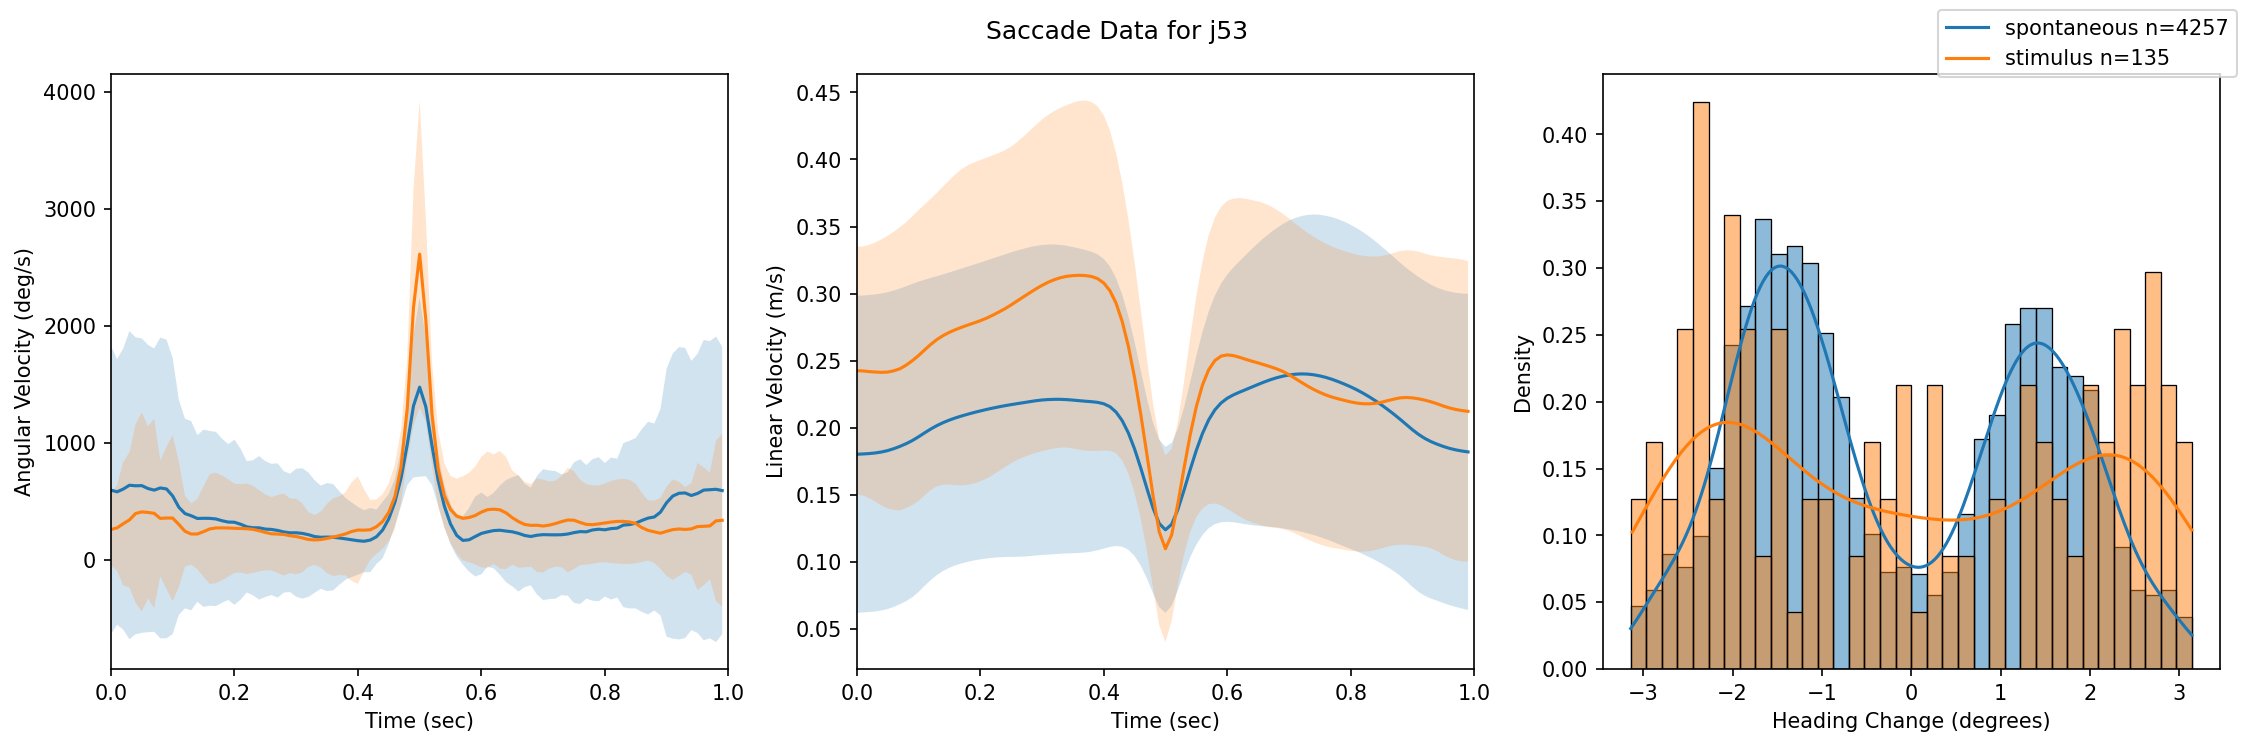

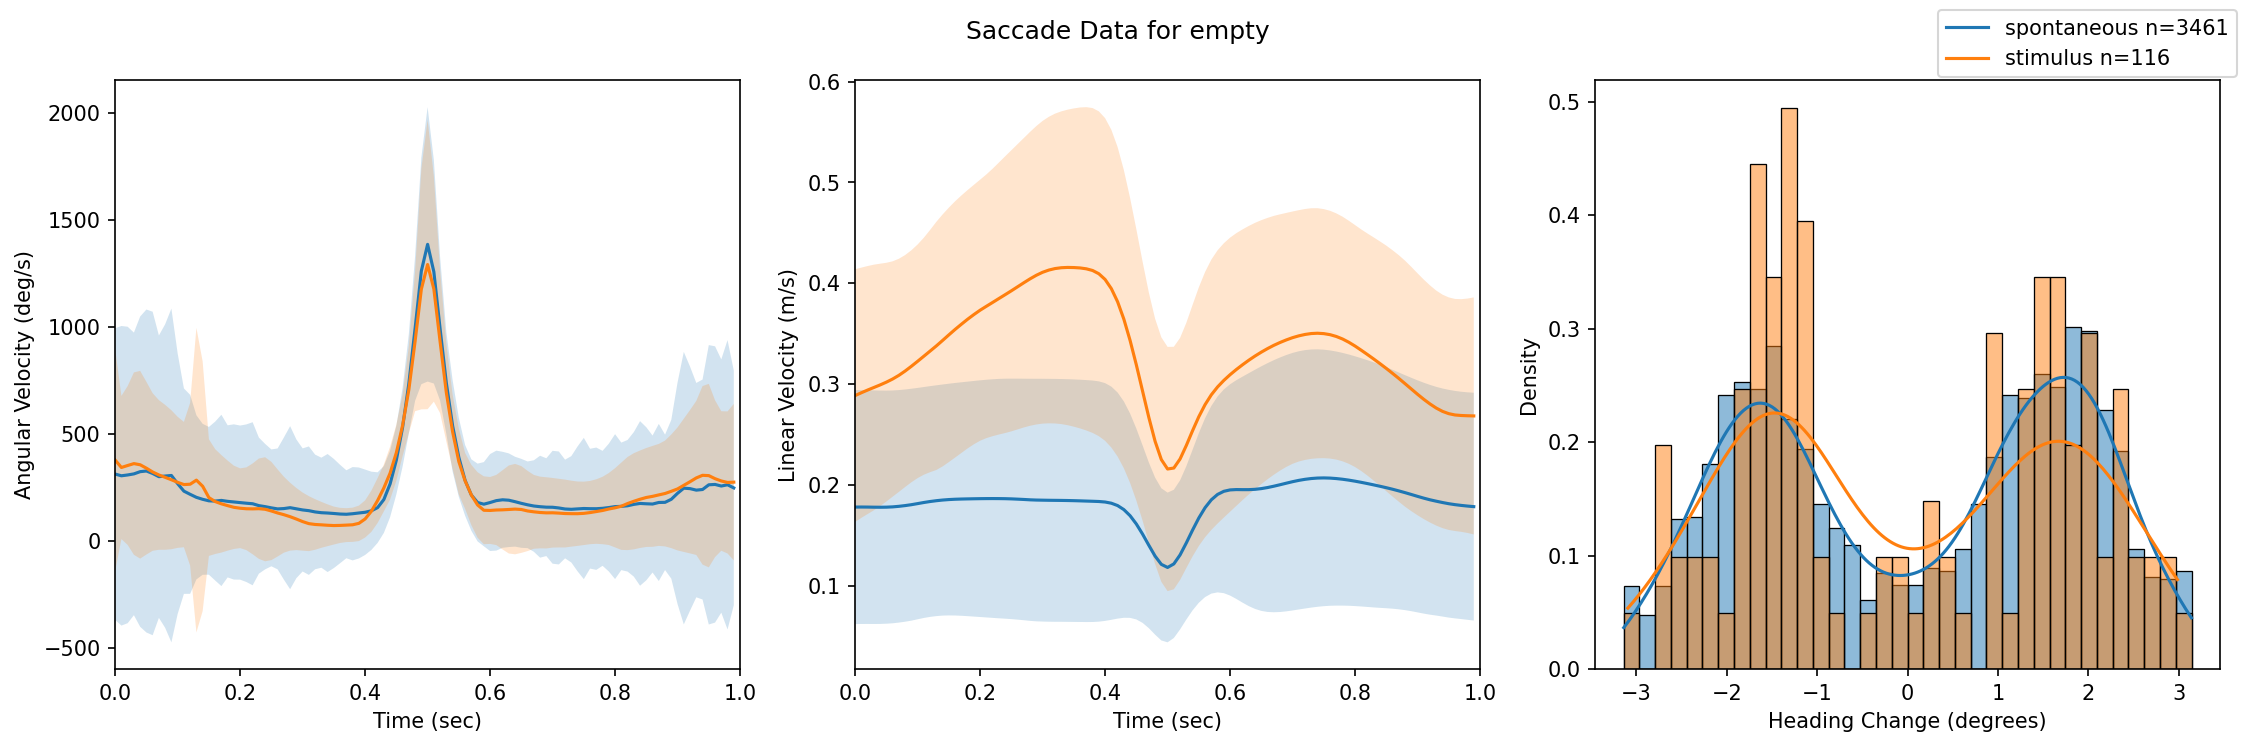

In [6]:
def plot_saccade_data(angvels, linvels, heading_changes, group, fly_line):
    fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5), dpi=150)

    ## angular velocity
    # plot mean and std for spontaneous saccades
    plot_mean_and_std(
        angvels[group == "spont"],
        ax=axs[0],
        label=f"spontaneous n={sum(group == 'spont')}",
    )

    # plot mean and std for stim saccades
    plot_mean_and_std(
        angvels[group == "stim"],
        ax=axs[0],
        label=f"stimulus n={sum(group == 'stim')}",
    )

    ## linear velocity
    # plot mean and std for spontaneous saccades
    plot_mean_and_std(linvels[group == "spont"], ax=axs[1])

    # plot mean and std for stim saccades
    plot_mean_and_std(linvels[group == "stim"], ax=axs[1])


    for ax in axs[:2]:
        ax.set_xlabel("Time (sec)")
        ax.set_xlim(0, 1)

    axs[0].set_ylabel("Angular Velocity (deg/s)")
    axs[1].set_ylabel("Linear Velocity (m/s)")

    ## heading change
    heading_changes_degrees = np.rad2deg(heading_changes)

    # plot histogram for spontaneous saccades
    sns.histplot(
        heading_changes[group == "spont"],
        ax=axs[2],
        bins=36,
        binrange=(-np.pi, np.pi),
        stat="density",
        kde=True,
    )

    # plot histogram for stim saccades
    sns.histplot(
        heading_changes[group == "stim"],
        ax=axs[2],
        bins=36,
        binrange=(-np.pi, np.pi),
        stat="density",
        kde=True,
    )

    axs[2].set_xlabel("Heading Change (degrees)")
    axs[2].set_ylabel("Density")

    fig.legend()
    plt.suptitle(f"Saccade Data for {fly_line}")

    plt.tight_layout()
    plt.show()

plot_saccade_data(g29_angvels, g29_linvels, g29_heading_changes, g29_group, fly_line="g29")
plot_saccade_data(j53_angvels, j53_linvels, j53_heading_changes, j53_group, fly_line="j53")
plot_saccade_data(empty_angvels, empty_linvels, empty_heading_changes, empty_group, fly_line="empty")